# Natural Language Processing with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not

In [66]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import nltk #natural language toolkit
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

import string
import re
from collections import Counter

In [2]:
current_directory = os.getcwd()

# Path to your Excel file
train_file_path = current_directory+'/train.csv'
train = pd.read_csv(train_file_path)
train.head()

test_file_path = current_directory+'/test.csv'
test = pd.read_csv(test_file_path)
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Data Cleaning tools

In [9]:
# Removing stopwords

pem_directory = current_directory + '/cacert.pem'
os.environ['SSL_CERT_FILE'] = pem_directory
#nltk.data.path.append(current_directory +"/nltk_data")
nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

# Example usage:
text_with_stopwords = "This is an example sentence with some stopwords."
text_without_stopwords = remove_stopwords(text_with_stopwords)
print("Text without stopwords:", text_without_stopwords)

Text without stopwords: example sentence stopwords .


[nltk_data] Downloading package stopwords to /Users/josh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/josh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
# remove punctuation

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# Example usage:
text_with_punctuation = "This is an example sentence with some punctuation!"
text_without_punctuation = remove_punctuation(text_with_punctuation)
print("Text without punctuation:", text_without_punctuation)

Text without punctuation: This is an example sentence with some punctuation


In [38]:
# Removing URLs

def remove_url(text):
    url = re.compile(r"https?://\S+|www\.\S+|http://\S+")
    return url.sub(r"", text)

# Example usage
text_with_urls = "Visit https://example.com for more info or check www.anotherexample.com. Also, http://example.org is useful."
text_without_url = remove_url(text_with_urls)
print("Text without url:", text_without_url)

Text without url: Visit  for more info or check  Also,  is useful.


In [14]:
# Tokenization

# Tokenization is a process which splits an input text into tokens
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# Example usage
text = "Heard about #earthquake is different cities, stay safe everyone."
print("Tokenization by regular expression:- ",tokenizer.tokenize(text))

Tokenization by regular expression:-  ['Heard', 'about', 'earthquake', 'is', 'different', 'cities', 'stay', 'safe', 'everyone']


In [18]:
# Stemming and Lemmatization
# Stemming: Removing and replacing suffixes to get to the root form of the word, which is called the stem for instance cats - cat, wolves - wolv
# Lemmatization : Returns the base or dictionary form of a word, which is known as the lemma

# Stemmer
stemmer = nltk.stem.PorterStemmer()

# Lemmatizer
nltk.download('wordnet')
lemmatizer=nltk.stem.WordNetLemmatizer()

# Example usage
text = "Heard about #earthquake is different cities, stay safe everyone."
tokens = tokenizer.tokenize(text)
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

[nltk_data] Downloading package wordnet to /Users/josh/nltk_data...


Stemming the sentence:  heard about earthquak is differ citi stay safe everyon
Lemmatizing the sentence:  Heard about earthquake is different city stay safe everyone


In [51]:
def data_processing(text):
    '''
    makes text lower
    removes stopwords
    removes punctuation
    removes urls
    '''
    #Initiate a tokenizer
    #tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text = text.lower()
    #text = remove_url(text)
    text = re.sub(r"https?://\S+|www\.\S+|http://\S+", "", text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    return text

In [19]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [61]:
train_processed = train
train_processed['text'] = train_processed['text'].apply(lambda x: data_processing(x))
train_processed.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [62]:
test_processed = test
test_processed['text'] = test_processed['text'].apply(lambda x: data_processing(x))
test_processed.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 china taiwan


## Data Exploration

Text(0.5, 0, 'non disaster tweets (0) vs disaster tweets (1)')

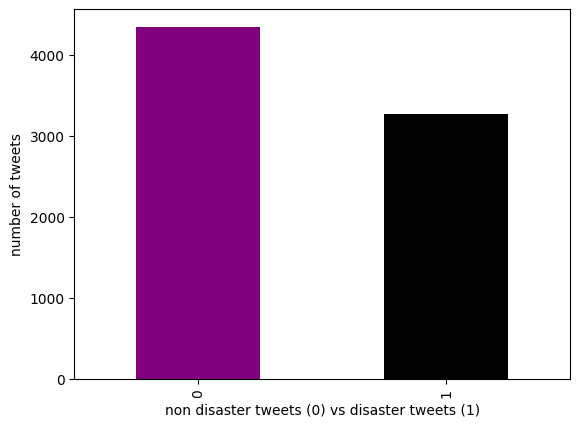

In [5]:
bars = train.value_counts("target").plot(kind='bar', color=['purple', 'black'])
plt.ylabel("number of tweets")
plt.xlabel("non disaster tweets (0) vs disaster tweets (1)")

In [8]:
# most common keywords
train['keyword'].value_counts()
print(train['keyword'].value_counts().head())

fatalities    45
deluge        42
armageddon    42
sinking       41
damage        41
Name: keyword, dtype: int64


In [9]:
# most common locations
train['location'].value_counts()
print(train['location'].value_counts().head())

USA              104
New York          71
United States     50
London            45
Canada            29
Name: location, dtype: int64


In [36]:
# Most common words

# Helper function for counting the amount of something in a dataset
def count_df(df):
    counter = Counter()

    for i in df:
        for w in i.split():
            counter[w] +=1

    return counter

Text(0, 0.5, 'word count')

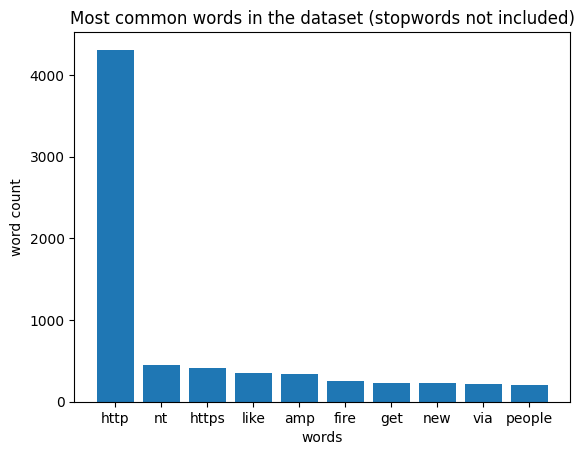

In [54]:
most_common_text = count_df(train_processed["text"]).most_common(10)
most_common_text_items, most_common_text_values = zip(*most_common_text)
plt.bar(most_common_text_items, most_common_text_values)
plt.title("Most common words in the dataset (stopwords not included)")
plt.xlabel("words")
plt.ylabel("word count")

Text(0, 0.5, 'word count')

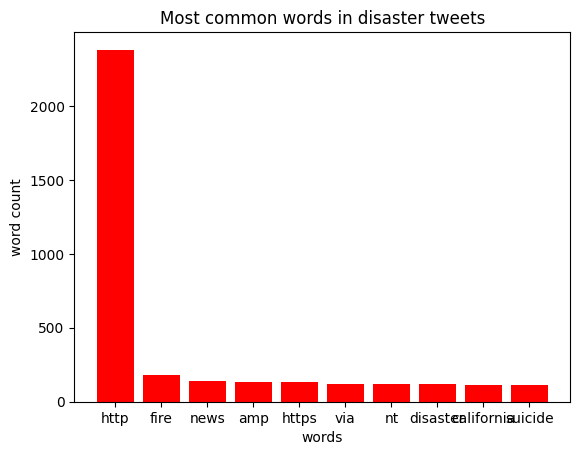

In [56]:
most_common_text_d = count_df(train_processed.loc[train_processed["target"]==True]["text"]).most_common(10)
most_common_text_d_items, most_common_text_d_values = zip(*most_common_text_d)
plt.bar(most_common_text_d_items, most_common_text_d_values, color='r')
plt.title("Most common words in disaster tweets")
plt.xlabel("words")
plt.ylabel("word count")

## Term Frequency

<b>Term Frequency</b>: is a scoring of the frequency of the word in the current document.

`TF = (Number of times term t appears in a document)/(Number of terms in the document)`

<b>Inverse Document Frequency</b>: is a scoring of how rare the word is across documents.

`IDF = 1+log(N/n)`, where, N is the number of documents and n is the number of documents a term t has appeared in.

In [63]:
# Vectorize the text using CountVectorizer
count_vectorizer = CountVectorizer()
train_cv = count_vectorizer.fit_transform(train_processed['text'])
test_cv = count_vectorizer.transform(test_processed["text"])

## Keeping only non-zero elements to preserve space 
print(train_cv[0].todense())

[[0 0 0 ... 0 0 0]]


In [59]:
train_cv

<7613x22024 sparse matrix of type '<class 'numpy.int64'>'
	with 77605 stored elements in Compressed Sparse Row format>

In [64]:
train_processed.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


## Classification

In [ ]:
#Split the CountVector vectorized data into train and test datasets for model training and testing
X_train_cv, X_test_cv, y_train_cv, y_test_cv =train_test_split(train_cv,train_df.target,test_size=0.2,random_state=42)


In [67]:
# logistic regression
lr = LogisticRegression(C=1.0)
model = lr.fit(train_cv, train_processed.target)
print ("R^2 is: \n", model.score(train_cv, train_processed.target))

R^2 is: 
 0.9665046630763168


In [71]:
# make predictions
test_processed["target"] = model.predict(test_cv)
test_processed.head()

,id,keyword,location,text,target
0,0,NaN,NaN,happened terrible car crash,1
1,2,NaN,NaN,heard earthquake different cities stay safe ev...,1
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...,1
3,9,NaN,NaN,apocalypse lighting spokane wildfires,0
4,11,NaN,NaN,typhoon soudelor kills 28 china taiwan,1


In [73]:
submission = test_processed[['id', 'target']]
submission.to_csv('submission.csv', index=False)